In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
sp.init_printing(use_unicode=True,fontsize=24)

from collections import OrderedDict


class Map1D():
    def __init__(self, q_map,p_map,q,p):


        # Base Variables
        #-----------------------
        self.q,self.p          = q,p
        self.q_map,self.p_map  = q_map,p_map
        self.jacobian          = sp.Matrix([[self.q_map.diff(self.q),self.q_map.diff(self.p)],
                                            [self.p_map.diff(self.q),self.p_map.diff(self.p)]])
        #-----------------------

        # Numerical Iteration
        #-----------------------
        self.q_iter = sp.lambdify((self.q,self.p),self.q_map)
        self.p_iter = sp.lambdify((self.q,self.p),self.p_map)
        #-----------------------


        # Constants for perturbation expansion
        #-----------------------
        self.C     = sp.IndexedBase('C')
        self.eps   = sp.symbols('epsilon',real=True)
        self.C_cs  = sp.symbols('C_cs',real=True)
        #-----------------------

        # Perturbation Expansion, (q,p) -> (eps*q,eps*p)
        #-----------------------
        self.q_eps             = (1/self.eps*q_map.subs({self.q:self.eps*self.q,
                                                        self.p:self.eps*self.p},simultaneous=True)).expand()
                                                
        self.p_eps             = (1/self.eps*p_map.subs({self.q:self.eps*self.q,
                                                        self.p:self.eps*self.p},simultaneous=True)).expand()
        #-----------------------

        
        # Creating the K's
        #-----------------------
        self.max_order = 10
        for n in range(self.max_order+1):
            self.__setattr__(f'K{n}',self.make_K(self.lex_power(n)))
        #-----------------------


    def lex_power(self,order):
        # ex for K1 : [(3,0),(2,1),(1,2),(0,3)] -> x**3 + x**2*y + x*y**2 + y**3
        return [(m,n) for n in range(13) for m in range(13) if n+m==order+2]


    def cycle(self,q0,p0,n_cycles):
        # To symbolically cycle the map
        q_prime,p_prime = q0,p0
        for i in range(n_cycles):
            q_prime,p_prime = self.q_map.subs({self.q:q_prime,self.p:p_prime},simultaneous=True),self.p_map.subs({self.q:q_prime,self.p:p_prime},simultaneous=True)
        return q_prime,p_prime

    def iterate(self,q0,p0,n_turns):
        # To numerically iterate the map
        q_vec,p_vec = np.nan*np.ones(n_turns),np.nan*np.ones(n_turns)
        q_vec[0],p_vec[0] = q0,p0
        for ii in range(n_turns-1):
            q_vec[ii+1],p_vec[ii+1] = self.q_iter(q_vec[ii],p_vec[ii]),self.p_iter(q_vec[ii],p_vec[ii])
        return q_vec,p_vec
        
        
    def truncate(self,expr,order):
        return sum(coeff*self.q**pwr[0]*self.p**pwr[1] for pwr,coeff in sp.Poly(expr,self.q,self.p).terms() if pwr[0]+pwr[1]<=order)

    def make_K(self,powers):
        expr   = sum(self.C[pwr[0],pwr[1]]*self.q**pwr[0]*self.p**pwr[1] for pwr in powers)
        return expr

    def Kofn(self,order):
        return sum((self.eps**n)*self.__getattribute__(f'K{n}') for n in range(order+1))

    def residue(self,order):
        K =  self.Kofn(order)
        return (K.subs({self.q:self.truncate(self.q_eps,order+1),
                        self.p:self.truncate(self.p_eps,order+1)},simultaneous=True) - K).expand()


    def solve_C(self,order,verbose=False,auto_update=True):


        to_cancel = self.residue(order).as_coefficients_dict(self.eps)[self.eps**order]
        eq_list = list(to_cancel.as_coefficients_dict(self.p,self.q).values())


        if order == 0:
            # Check that the map is symplectic (or close enough)
            assert np.isclose(np.float64(self.jacobian.det()-1),0, rtol=1e-9,atol=1e-9), 'Map is not symplectic'

            # Analytic solution for K0 to enforce symplecticity
            _coeff_q = self.q_eps.expand().as_coefficients_dict(self.q,self.p)
            _coeff_p = self.p_eps.expand().as_coefficients_dict(self.q,self.p)
            a  = _coeff_q[self.q]
            b  = _coeff_q[self.p]
            c  = _coeff_p[self.q]
            d  = _coeff_p[self.p]

            to_sub = {self.C[1,1]:(b*c-d**2+1)/(b*d) * self.C_cs, self.C[2,0]:-c*self.C_cs/b,self.C[0,2]:self.C_cs}

        else:
            # Solve the system of equations
            to_sub = sp.solve(eq_list,[self.C[i] for i in self.lex_power(order)])

        if verbose:
            print(60*'-')
            for key,item in to_cancel.as_coefficients_dict(self.p,self.q).items():
                display((sp.Matrix([key]),item))
        
        if auto_update:
            self.update(to_sub,verbose=verbose)
        elif verbose:
            display(to_sub)
        
        if verbose:
            print(60*'-')


    def update(self,to_update,verbose=False,deep_update=False):
        if verbose:
            display(to_update)

        for n in range(self.max_order+1):
            # updating the expression
            self.__setattr__(f'K{n}', self.__getattribute__(f'K{n}').subs(to_update, simultaneous=True))

        # Rewrite all variables if needed
        if deep_update:
            for attr in ['q_map','p_map','q_eps','p_eps']:
                self.__setattr__(attr, self.__getattribute__(attr).subs(to_update, simultaneous=True))

            self.q_iter = sp.lambdify((self.q,self.p),self.q_map)
            self.p_iter = sp.lambdify((self.q,self.p),self.p_map)



def plot_invariant(expr,q,p,eval_at = None,**kwargs):
    K = sp.lambdify((q,p),expr)

    

    if eval_at is not None:
        q_list,p_list = eval_at
        q_list = np.array(q_list)
        p_list = np.array(p_list)

        levels = K(q_list,p_list)
        
        kwargs.update({'levels':np.sort(levels)})

        multiplier = 1
        window = ((multiplier *q_list,-multiplier *q_list,multiplier *p_list,-multiplier *p_list))
        Q,P = np.meshgrid(  np.linspace(np.min(window),np.max(window),500),
                            np.linspace(np.min(window),np.max(window),500))

    else:
        Q,P = np.meshgrid(  np.linspace(-10,10,10000),
                            np.linspace(-10,10,10000))
    plt.contour(Q,P,K(Q,P),**kwargs)




---
# Example with Henon map
---

In [2]:

x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP

xp  =  px
pxp =  -x +a*px + px**3

#=========================

print('Map')
display(xp,pxp)

henon = Map1D(xp,pxp,x,px)

Map


# Perturbation theory requires us to look for solutions of the form

$$ K = K_0 + \varepsilon K_1 + \varepsilon^2 K_2 + \dots$$

In [3]:
display(henon.K0)
display(henon.K1)
display(henon.K2)
display(henon.K3)

# We have our perturbation expansion of the map

In [4]:
display(henon.q_eps)
display(henon.p_eps)

# So we can solve for the coefficients by minimizing the residue
### Note: this leaves us with a free parameter: the courant-snyder invariant. We can set it to 1 since the invariant can be rescaled. Free parameters at higher orders will need to be minmized in a better fashion


In [5]:
display(henon.residue(order = 0))
henon.solve_C(order = 0,verbose=True,auto_update=True)
display(henon.K0.collect(henon.C_cs))

------------------------------------------------------------


------------------------------------------------------------


---

---
# TESTING AFTER THIS POINT
---


Map


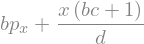

------------------------------------------------------------


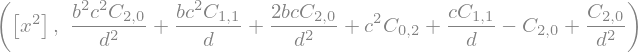

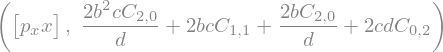

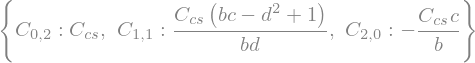

------------------------------------------------------------
Symplectic?


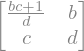

In [122]:

x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP

xp  = a*x + b*px
pxp = c*x + d*px

xp = xp.subs({a:(b*c + 1)/d})

#=========================

print('Map')
display(xp,pxp)

test = Map1D(xp,pxp,x,px)
test.solve_C(0,verbose=True,auto_update=False)

print('Symplectic?')
M = sp.Matrix([[sp.Derivative(test.q_map,test.q).doit(),sp.Derivative(test.q_map,test.p).doit()],
                [sp.Derivative(test.p_map,test.q).doit(),sp.Derivative(test.p_map,test.p).doit()]])
display(M,M.det())


In [129]:
test.K0.collect(test.C_cs)

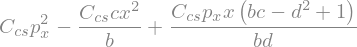

In [78]:
test.K0

In [59]:
sp.latex(sp.solve(test.jacobian.det()-1,a)[0])

'\\frac{b c + 1}{d}'

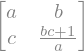

In [47]:
test.jacobian

In [120]:
np.float64(test.jacobian.det()-1)

numpy.float64

In [118]:
np.isclose(np.float64(test.jacobian.det()-1),0, atol=1e-20)

False

In [106]:
np.float64(test.jacobian.det())-1

In [95]:
test.jacobian.det()-1

In [123]:

x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
xp  = -0.901562491050713*x -0.426069762027653*px
pxp =  0.404595926626569*x -0.917977309437898*px


#=========================

print('Map')
display(xp,pxp)

test = Map1D(xp,pxp,x,px)
test.solve_C(0,verbose=True,auto_update=True)
# test.update({a:-0.901562491050713,b:-0.426069762027653,c:0.404595926626569,d:-0.917977309437898},verbose=True,deep_update=True)

test.solve_C(1,verbose=True)
test.solve_C(2,verbose=True)

# xp  = -0.901562491050713*x -0.426069762027653*px
# pxp =  0.404595926626569*x -0.917977309437898*px



plt.figure()

x_points = np.linspace(0,1,20)
px_points = 0.25*np.linspace(0,1,20)

plot_invariant(test.Kofn(2).subs({test.C[0,2]:1,test.eps:1}),test.q,test.p,eval_at=[x_points,px_points],colors='C0',alpha=0.9)
for part_x,part_px in zip(x_points,px_points):
    _x,_px =  test.iterate(part_x,part_px,2000)
    plt.plot(_x,_px,'o',color='k',alpha=0.5,ms=1,label='space')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)



Map


------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------


TypeError: cannot determine truth value of Relational

<Figure size 640x480 with 0 Axes>

Map


------------------------------------------------------------


------------------------------------------------------------
Symplectic?


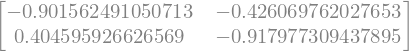

In [37]:

x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
xp  = -0.901562491050713*x -0.426069762027653*px
pxp =  0.404595926626569*x -0.917977309437898*px


xp  = a*x + b*px
pxp = c*x + d*px

pxp = pxp.subs({d:(b*c+1)/a})
xp  = xp.subs({a: -0.901562491050713,
               b: -0.426069762027653,},simultaneous=True)
pxp = pxp.subs({a: -0.901562491050713,b: -0.426069762027653,c: 0.404595926626569},simultaneous=True)

#=========================

print('Map')
display(xp,pxp)

test = Invariant(xp,pxp,x,px)
test.solve_C(0,verbose=True,auto_update=False)

print('Symplectic?')
M = sp.Matrix([[sp.Derivative(test.q_map,test.q).doit(),sp.Derivative(test.q_map,test.p).doit()],
                [sp.Derivative(test.p_map,test.q).doit(),sp.Derivative(test.p_map,test.p).doit()]])
display(M,M.det())



Map


------------------------------------------------------------


------------------------------------------------------------
Symplectic?


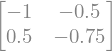

In [3]:


x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
xp  =   -1*x  -0.5*px
pxp =  0.5*x -0.75*px

#=========================

print('Map')
display(xp,pxp)

test = Invariant(xp,pxp,x,px)
test.solve_C(0,verbose=True,auto_update=False)

print('Symplectic?')
M = sp.Matrix([[sp.Derivative(test.q_map,test.q).doit(),sp.Derivative(test.q_map,test.p).doit()],
                [sp.Derivative(test.p_map,test.q).doit(),sp.Derivative(test.p_map,test.p).doit()]])
display(M,M.det())

Map


------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


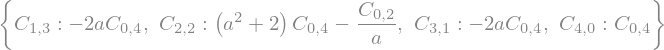

------------------------------------------------------------
Symplectic?


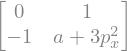

In [38]:


x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
xp  =  px
pxp =  -x +a*px + px**3

#=========================

print('Map')
display(xp,pxp)

test = Invariant(xp,pxp,x,px)
test.solve_C(0,verbose=True)
test.solve_C(1,verbose=True)
test.solve_C(2,verbose=True)

print('Symplectic?')
M = sp.Matrix([[sp.Derivative(test.q_map,test.q).doit(),sp.Derivative(test.q_map,test.p).doit()],
                [sp.Derivative(test.p_map,test.q).doit(),sp.Derivative(test.p_map,test.p).doit()]])
display(M,M.det())


In [36]:
test.K0

---
# Iterating the map
---

In [163]:
test.q_iter.subs({a:0.5})

AttributeError: 'function' object has no attribute 'subs'

In [157]:
test.K0

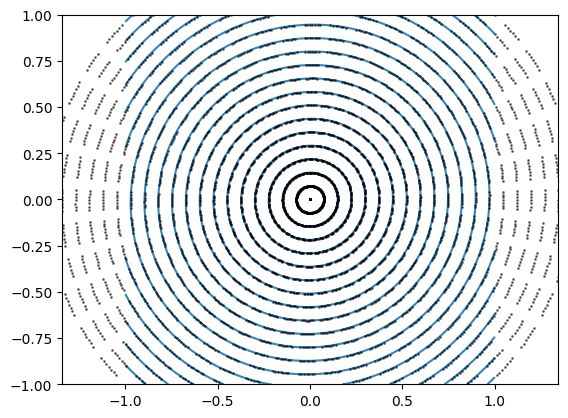

In [125]:

# x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

# #=========================
# # MAP
# xp  = -0.901562491050713*x -0.426069762027653*px
# pxp =  0.404595926626569*x -0.917977309437898*px

# #=========================

# print('Map')
# display(xp,pxp)

# test = Invariant(xp,pxp,x,px)




plt.figure()

x_points = np.linspace(0,1,20)
px_points = np.linspace(0,1,20)

plot_invariant(test.K0.subs({test.C_cs:1}),test.q,test.p,eval_at=[x_points,px_points],colors='C0',alpha=0.9)
for part_x,part_px in zip(x_points,px_points):
    _x,_px =  test.iterate(part_x,part_px,300)
    plt.plot(_x,_px,'o',color='k',alpha=0.5,ms=1,label='space')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)

Map


------------------------------------------------------------


------------------------------------------------------------


<lambdifygenerated-24>:2: RuntimeWarning: overflow encountered in scalar power
  return p_x**3 + 0.5*p_x - x
<lambdifygenerated-24>:2: RuntimeWarning: invalid value encountered in scalar subtract
  return p_x**3 + 0.5*p_x - x


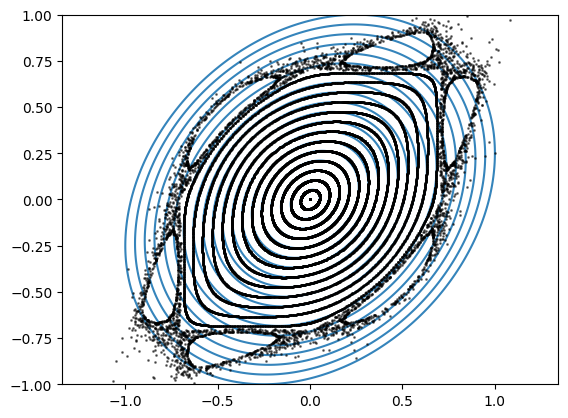

In [40]:


x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
a = 0.5
xp  =  px
pxp =  -x +a*px + px**3

#=========================

print('Map')
display(xp,pxp)

test = Invariant(xp,pxp,x,px)
test.solve_C(0,verbose=True)

plt.figure()

x_points = np.linspace(0,1,20)
px_points = 0.25*np.linspace(0,1,20)

plot_invariant(test.K0.subs({test.C[0,2]:1}),test.q,test.p,eval_at=[x_points,px_points],colors='C0',alpha=0.9)
for part_x,part_px in zip(x_points,px_points):
    _x,_px =  test.iterate(part_x,part_px,2000)
    plt.plot(_x,_px,'o',color='k',alpha=0.5,ms=1,label='space')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)


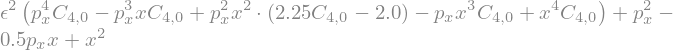

In [42]:
test.Kofn(2)

Map


------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------


<lambdifygenerated-30>:2: RuntimeWarning: overflow encountered in scalar power
  return p_x**3 + 0.5*p_x - x
<lambdifygenerated-30>:2: RuntimeWarning: invalid value encountered in scalar subtract
  return p_x**3 + 0.5*p_x - x


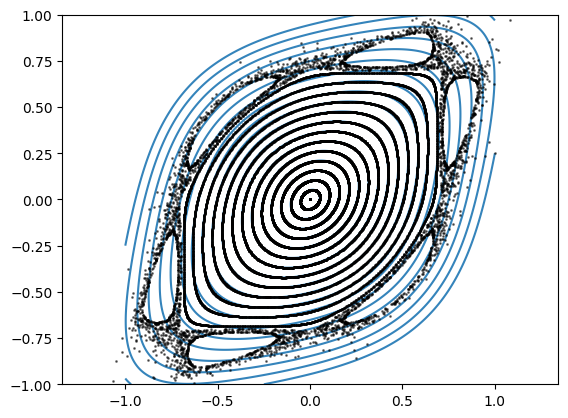

In [42]:


x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
a = 0.5
xp  =  px
pxp =  -x +a*px + px**3

#=========================

print('Map')
display(xp,pxp)

test = Invariant(xp,pxp,x,px)
test.solve_C(0,verbose=True)
test.update({test.C[0,2]:1})
test.solve_C(1,verbose=True)
test.solve_C(2,verbose=True)

plt.figure()

x_points = np.linspace(0,1,20)
px_points = 0.25*np.linspace(0,1,20)

plot_invariant(test.Kofn(2).subs({test.C[0,4]:1,test.eps:1}),test.q,test.p,eval_at=[x_points,px_points],colors='C0',alpha=0.9)
for part_x,part_px in zip(x_points,px_points):
    _x,_px =  test.iterate(part_x,part_px,2000)
    plt.plot(_x,_px,'o',color='k',alpha=0.5,ms=1,label='space')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)


Map


------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------


<lambdifygenerated-80>:2: RuntimeWarning: overflow encountered in scalar power
  return p_x**3 + 0.5*p_x - x
<lambdifygenerated-80>:2: RuntimeWarning: invalid value encountered in scalar subtract
  return p_x**3 + 0.5*p_x - x


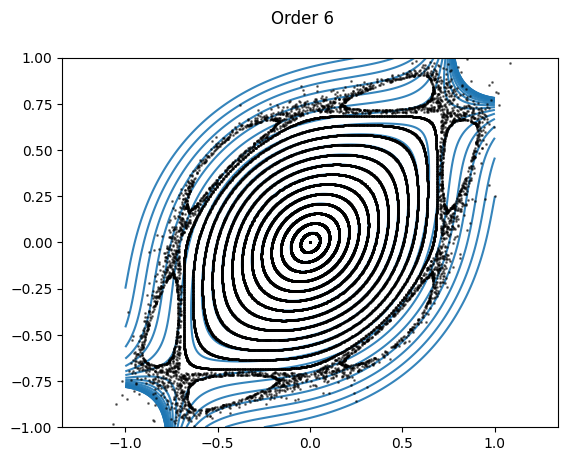

In [132]:


x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
a = 0.5
xp  =  px
pxp =  -x +a*px + px**3

#=========================

print('Map')
display(xp,pxp)

test = Map1D(xp,pxp,x,px)
test.solve_C(0,verbose=False)
test.update({test.C_cs:1})
test.solve_C(1,verbose=False)
test.solve_C(2,verbose=False)
test.update({test.C[0,4]:1})
test.solve_C(3,verbose=True)
test.solve_C(4,verbose=True)
test.update({test.C[0,6]:1})

test.solve_C(5,verbose=True)
test.solve_C(6,verbose=True)
test.update({test.C[0,8]:1})


n = 6

plt.figure()
plt.suptitle(f'Order {n}')
x_points = np.linspace(0,1,20)
px_points = 0.25*np.linspace(0,1,20)

plot_invariant(test.Kofn(n).subs({test.eps:1}),test.q,test.p,eval_at=[x_points,px_points],colors='C0',alpha=0.9)
for part_x,part_px in zip(x_points,px_points):
    _x,_px =  test.iterate(part_x,part_px,2000)
    plt.plot(_x,_px,'o',color='k',alpha=0.5,ms=1,label='space')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)


Map


------------------------------------------------------------


------------------------------------------------------------


<lambdifygenerated-186>:2: RuntimeWarning: overflow encountered in scalar power
  return p_x**3 + 0.5*p_x - x
<lambdifygenerated-186>:2: RuntimeWarning: invalid value encountered in scalar subtract
  return p_x**3 + 0.5*p_x - x


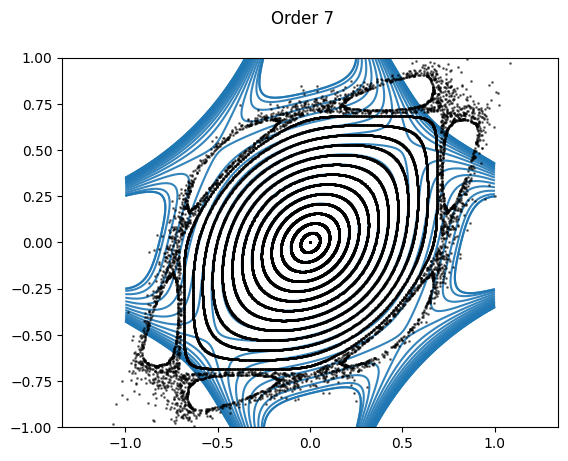

In [134]:


x,px,a,b,c,d = sp.symbols('x p_x a b c d',real=True)

#=========================
# MAP
a = 0.5
xp  =  px
pxp =  -x +a*px + px**3

#=========================

print('Map')
display(xp,pxp)

test = Invariant(xp,pxp,x,px)
test.solve_C(0,verbose=False)
test.update({test.C[2,0]:1})
test.solve_C(1,verbose=False)
test.solve_C(2,verbose=False)
test.update({test.C[4,0]:0})
test.solve_C(3,verbose=False)
test.solve_C(4,verbose=False)
test.update({test.C[6,0]:0})

test.solve_C(5,verbose=False)
test.solve_C(6,verbose=False)
test.update({test.C[8,0]:0})

test.solve_C(7,verbose=True)
# test.update({test.C[10,0]:0})
# test.update({test.C[0,10]:0})
# test.solve_C(8,verbose=True)
# test.update({test.C[10,0]:0})


n = 7

plt.figure()
plt.suptitle(f'Order {n}')
x_points = np.linspace(0,1,20)
px_points = 0.25*np.linspace(0,1,20)

plot_invariant(test.Kofn(n).subs({test.eps:1}),test.q,test.p,eval_at=[x_points,px_points],colors='C0',alpha=0.9)
for part_x,part_px in zip(x_points,px_points):
    _x,_px =  test.iterate(part_x,part_px,2000)
    plt.plot(_x,_px,'o',color='k',alpha=0.5,ms=1,label='space')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)


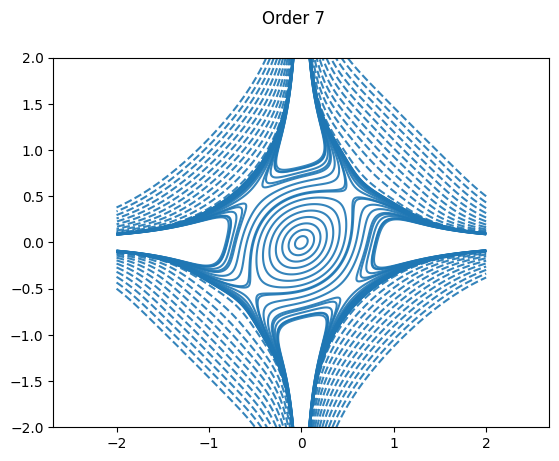

In [135]:
plt.figure()
plt.suptitle(f'Order {n}')
x_points = np.linspace(0,2,30)
px_points = 0.25*np.linspace(0,2,30)

plot_invariant(test.Kofn(n).subs({test.eps:1}),test.q,test.p,eval_at=[x_points,px_points],colors='C0',alpha=0.9)

# for part_x,part_px in zip(x_points,px_points):
#     _x,_px =  test.iterate(part_x,part_px,2000)
#     plt.plot(_x,_px,'o',color='k',alpha=0.5,ms=1,label='space')

plt.axis('equal')
# plt.xlim(-1,1)
# plt.ylim(-1,1)

In [8]:


x,px,a,b,c,d,e,f = sp.symbols('x p_x a b c d e f',real=True)

#=========================
# MAP

xp  =  px
pxp =  -x +a*px + b*px**2 + c*px**3 + d*px**4 + e*px**5 + f*px**6

#=========================

print('Map')
display(xp,pxp)

test = Map1D(xp,pxp,x,px)



Map


In [21]:
xp,pxp = test.cycle(test.q,test.p,0)
for i in range(3):
    xp,pxp = test.cycle(xp,pxp,1)
    xp = (xp.expand() + sp.O(x**3) + sp.O(px**3)).removeO()
    pxp = (pxp.expand() + sp.O(x**3) + sp.O(px**3)).removeO()

display((xp+ sp.O(x**3) + sp.O(px**3)).as_coefficients_dict(x,px))
display((pxp+ sp.O(x**3) + sp.O(px**3)).as_coefficients_dict(x,px))
